### **Andamento do Projeto Paper Model - Maio/22**

### **Ideia**

Utilizar heurísticas do problema de Bin Packing 2d com retângulos para encaixar as peças do paper model em uma folha A4.

### **Modelagem**
Todo o projeto está sendo estruturado em Python utilizando orientação a objetos para modelar o problema. As princiais entidades modeladas são as seguintes:

1. **Segment:** Represente um segmento de reta modelado como dois pares de pontos `(x0, y0) -> (x1, y1)`.
2. **Polygon:** É um conjunto de segmentos que juntos representam uma figura fechada.
3. **Piece:** É a extensão de um polígono - Representa uma peça do paper model.
4. **Rect:** É um retângulo em que dois dos lados são paralelos ao eixo x. Por isso, é representado por um par ordenado `(x,y)` como sendo a coordenada do ponto inferior a esquerda, uma largura (`width`) e uma altura (`height`).
5. **MinBoundingRect:** Herda de um retângulo (`Rect`). É o menor retângulo que contém um polígono.
6. **PaperModel:** Uma clase capaz de ler um SVG e construir um conjunto de peças (`Piece`) e seus respectivos bounding rectangles (`MinBoundingRect`).

Além disso, o problema de Bin Packing 2d também é representado por classes que herdam das seguintes entidades:

1. **Bin:** Representa um Bin no problema de bin packing (no nosso caso, uma folha A4). Contém um método `insert`.
2. **PackingAlgorithm:** Representa o próprio algoritmo de packing e recebe no construtor os retângulos a serem empacotados. Contém um método `pack` e um conjunto de bins.

**Exemplo de uso**:


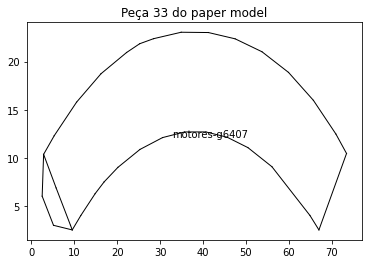

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib.pyplot as plt
from pynest.elements.papermodel import PaperModel

data_path = f"/workspaces/paper-model-nest/pynest/data/svgs"
model = PaperModel(svg_path=f"{data_path}/e190-e2.svg")

plt.title("Peça 33 do paper model")
model.pieces[32].plot()

### **Problema 1**: Como transformar as peças em retângulos para reduzir o problema a um Bin Packing 2d?

A ideia foi encontrar o menor retângulo delimitador (minimum bounding rectangle - MBR) para uma peça do paper model para ter a menor área vazia possível. Para isso, **é suficiente encontrar o menor bounding rectangle para o convex hull dos vértices da peça**. Este problema é mais fácil de resolver, pois pode-se mostrar que, para figuras convexas, o minimum bounding rectangle deve ser paralelo a um dos lados, o que reduz muito o número de retângulos que devem ser testados para se encontrar o de menor área.

Um problema desta abordagem é se o MBR tiver uma das dimensões maiores que o bin. Idealmente neste caso, queremos encontrar o MBR que caiba no bin.

Como é uma restrição do problema **ter um espaço mínimo de 5mm** entre as peças, aumentamos o bounding rectangle em 2.5mm em cada lado para cumprir este requisito

**Exemplo:**

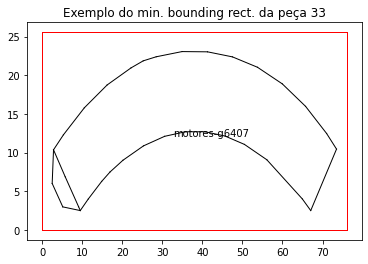

In [2]:
plt.title("Exemplo do min. bounding rect. da peça 33")
model.bounding_rects[32].plot()

### **Problema 2**: Como empacotar as peças em uma A4?

A primeira ideia foi utilizar um algoritmo da categoria de Maximal Rectangles Algorithms, que foi escolhido por apresentar o melhor desempenho no paper de referência. Esses algoritmos são uma extensão do método Guilhotina, em que a área livre do bin é representada por uma lista de retângulos livres. Os retângulos livres são construidos a partir da divisão da área livre do bin em múltiplos retângulos, conforme a ilustração abaixo. 

![](/workspaces/paper-model-nest/pynest/data/imgs/max_rects.png).


Na qual na inserção de um novo retângulo no bin, procura-se a "melhor" localização dentro de um dos retângulos livres disponíveis. Para escolher esta melhor localização, existem diversas heurísticas possíveis para o algoritmo de maximal rectangles. A primeira variante implementada foi a Bottom-Left (BL), em que critério de melhor localização é **encontrar o retângulo livre cuja altura do retângulo colocado seja mínima**. Caso haja empate, coloca-se na posição mais a esquerda no eixo x.

![](/workspaces/paper-model-nest/pynest/data/imgs/free_rects.png).

Pode-se mostrar que os algoritmos da categoria de Maximal Rectangles tem ordem $ O(\|F\|^2 n) $, em que $F$ é o conjunto dos retângulos livres e $n$ é o número de retângulos a serem empacotados.


### **Exemplo Harry Potter**

Um primeiro exemplo do algoritmo descrito acima para o paper model do Harry Potter é exibido abaixo. O bin foi considerado como a posição da folha A4 na horizontal e as peças inseridas na ordem que foram lidas no SVG disponibilizado.

Principalmente no segundo bin, nota-se que a inserção deixou muitos espaços vazios entre as peças. Aparentemente, caso a ordem de inserção fosse diferente ou pudéssemos rotacionar as peças, poderíamos reduzir o número de bins para 2.

In [6]:
from pynest.packing.bottomleft import BLPacker
from pynest.packing.sorter import SortMethod

sort_methods = [
    SortMethod.ASCA,
    SortMethod.DESCA,
    SortMethod.ASCSS,
    SortMethod.DESCSS,
    SortMethod.ASCLS,
    SortMethod.DESCLS,
    SortMethod.ASCRATIO,
    SortMethod.DESCRATIO,
    SortMethod.ASCDIFF,
    SortMethod.DESCDIFF,
    SortMethod.ASCPERIM,
    SortMethod.DESCPERIM
]

best_method = None
min_bins = 100000000000
free_area = 10000000000

for method in [SortMethod.DESCA]:
    print(method)
    model = PaperModel(svg_path=f"{data_path}/e190-e2.svg")
    packer = BLPacker(297,210, model.bounding_rects)
    packer.pack(allow_rotation=True, sort_by=SortMethod.DESCDIFF)

    if len(packer.bins) < min_bins:
        best_method = method
        min_bins = len(packer.bins)
        free_area = packer.bins[-1].free_area

    elif len(packer.bins) == min_bins:
        if packer.bins[-1].free_area > free_area:
            best_method = method
            free_area = packer.bins[-1].free_area

# for bin in packer.bins:
#     bin.plot()

desca
Creating new bin!
Creating new bin!
Creating new bin!
Creating new bin!


In [7]:
free_area

70366.76363224618

In [5]:
free_area

70366.76363224618

### **Próximos passos**

- Implementar métodos gerais para melhorar a inserção das peças no bin, como ordenar o input por área, escolher o bin de melhor fit ao invés de sempre tentar encaixar no primeiro.
- Implementar rotação dos retângulos de 90º - Eventualmente pode melhorar a inserção das peças no bin.
- Implementar outras heurísticas - Como os algoritmos da categoria de Maximal Rectangles são rápidos, podemos implementar diversas heurísticas de inserção e escolher a que deixa a menor área livre disponível.


### **Referências**

- Jukka Jylang - A Thousand Ways to Pack the Bin - A Practical Approach to Two-Dimensional Rectangle Bin Packing (2010)
- Rectpack repository: https://github.com/secnot/rectpack
- Greedypacker repository: https://github.com/solomon-b/greedypacker